# **Machine Learning Engineer — Technical Test**

This project develops a predictive model for weekly retail store sales using historical data from February 2010 to November 2012. The dataset includes store numbers, sales dates, weekly revenues, holiday indicators, temperature, fuel prices, CPI, and unemployment rates. Accurate sales forecasts will enable store managers to optimize operations, plan promotions effectively, and improve profitability.

Our approach follows a systematic pipeline: exploratory data analysis to understand patterns and detect anomalies, data preprocessing and feature engineering, model selection and training, performance evaluation with appropriate metrics

## **1- Exploratory data analysis**

### **1-1 Load and explore the data**

In [31]:
# Core Python libraries
import sys
import joblib

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt ## Plotly allows for more interactive and dynamic graphs
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Statistical tests & time series
from scipy.stats import chi2_contingency
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error

# Specialized models
import lightgbm as lgb
from prophet import Prophet

In [2]:
# Load the dataset and convert the 'date' column to datetime format
df = pd.read_csv('../data/stores-sales.csv', parse_dates=['date'], dayfirst=True)
df

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
# Statistiques globales
print(f" Dataset: {df.shape[0]} observations × {df.shape[1]} variables")
print(f" Période: from {df['date'].min().date()} to {df['date'].max().date()}")
print(f" Magasins: {df['store'].nunique()}")
print(f" Observations/magasin: {df.groupby('store').size().mean():.0f}")

 Dataset: 6435 observations × 8 variables
 Période: from 2010-02-05 to 2012-10-26
 Magasins: 45
 Observations/magasin: 143


Multi-Store Time Series Forecasting Approach : 

This project handles multiple time series (45 retail stores) using a hierarchical and clustered modeling strategy rather than building individual models per store. Three main approaches were compared:

Clustering + Model per Cluster: K-means clustering groups stores with similar patterns into 4 clusters, then trains one model (LightGBM or Prophet) per cluster. This reduces complexity from 45 to 4 models while capturing store similarities.
Top-Down Hierarchical: Predicts aggregate sales at the total level, then disaggregates predictions to clusters and stores using historical proportions. This ensures global coherence but may lose granular patterns.
Bottom-Up Hierarchical: Trains separate models per cluster at the aggregated cluster level, then distributes predictions to individual stores using historical proportions. This balances global trends with cluster-specific dynamics.

Models tested: LightGBM (gradient boosting) and Prophet (time series) with engineered features including lags, rolling statistics, cyclical encodings, and holiday flags.

### **1-2 Multiple Time Series Visualization**

In [4]:
fig = px.line(df, x='date', y='weekly_sales', color='store')
fig.update_layout(title='Time Series Evolution for All Stores', 
    xaxis_title='Date',
    yaxis_title='Weekly sales ($)',
    height=600)
fig.show()


In [5]:
stats = df.groupby('store')['weekly_sales'].agg(['mean', 'std']).reset_index()
fig = go.Figure(go.Bar(
    x=stats['store'],
    y=stats['mean'],
    error_y=dict(type='data', array=stats['std'], visible=True)
))
fig.update_layout(
    title='Average Weekly Sales per Store (± Std)',
    xaxis_title='Store',
    yaxis_title='Average Sales'
)
fig.show()

We see that the stores follow similar patterns, which suggests the influence of common external factors. At the same time, there are pronounced sales peaks at the end of the year (Q4), likely reflecting holiday effects but not for all stores. We also see significant differences in average sales levels between stores, highlighting heterogeneity, while high standard deviations indicate strong variability within individual stores.

### **1-3 Data quality check**

In [6]:
# Checking for duplicates
duplicates_exist = df.duplicated().any()
print(duplicates_exist) 

False


No duplicate data found

In [7]:
# Checking for missing values 
missing_values = df.isnull().sum()
missing_values

store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_Price      0
cpi             0
unemployment    0
dtype: int64

Also, No missing values found :)

In [8]:
# Ensuring the time series data is complete
all_good = True  
for store_id in sorted(df['store'].unique()):
    store_data = df[df['store'] == store_id].sort_values('date')
    date_diff = store_data['date'].diff().dt.days
    mode_diff = date_diff.mode()[0] if len(date_diff.mode()) > 0 else 7
    gaps = date_diff[date_diff > mode_diff + 1]
    
    print(f"Store {store_id}: {len(store_data)} obs, Frequency: {mode_diff} days, Gaps: {len(gaps)}")
    
    if len(gaps) > 0:
        all_good = False
# Final summary
if all_good:
    print("PERFECT: All time series are complete")
else:
    print("WARNING: Some stores have missing weeks")


Store 1: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 2: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 3: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 4: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 5: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 6: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 7: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 8: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 9: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 10: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 11: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 12: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 13: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 14: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 15: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 16: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 17: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 18: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 19: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 20: 143 obs, Frequency: 7.0 days, Gaps: 0
Store 21: 143 obs, Frequency: 7.0 days, Gaps: 0
S

Perfect! the time series data is complete

In [9]:
# HOLIDAY_FLAG COMPATIBILITY CHECK

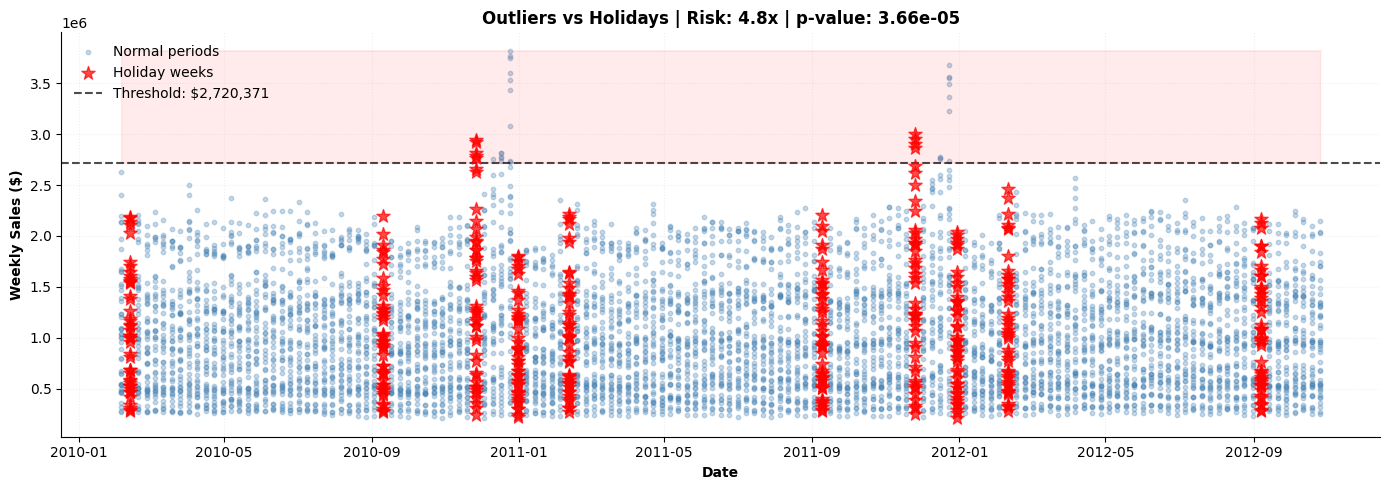

Outliers: 34 (0.53%)
Risk ratio: 4.79x | p-value: 3.66e-05


In [10]:
# Checking for outliers

df1 = df.copy()
df1['year'] = df1['date'].dt.year
df1['week'] = df1['date']

# Outlier detection
Q1, Q3 = df1['weekly_sales'].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
outliers = df1[df1['weekly_sales'] > upper_bound]

# Statistics
total_holidays = len(df1[df1['holiday_flag'] == 1])
total_normal = len(df1[df1['holiday_flag'] == 0])
prob_out_holiday = len(outliers[outliers['holiday_flag'] == 1]) / total_holidays
prob_out_normal = len(outliers[outliers['holiday_flag'] == 0]) / total_normal
risk_ratio = prob_out_holiday / prob_out_normal

# Chi² test
contingency = pd.crosstab((df1['weekly_sales'] > upper_bound), df1['holiday_flag'])
chi2, p_value, _, _ = chi2_contingency(contingency)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

ax.scatter(df1[df1['holiday_flag']==0]['date'], 
           df1[df1['holiday_flag']==0]['weekly_sales'], 
           alpha=0.3, s=10, color='steelblue', label='Normal periods')
ax.scatter(df1[df1['holiday_flag']==1]['date'], 
           df1[df1['holiday_flag']==1]['weekly_sales'], 
           s=100, color='red', marker='*', alpha=0.7, label='Holiday weeks', zorder=5)
ax.axhline(upper_bound, color='black', linestyle='--', linewidth=1.5, 
           label=f'Threshold: ${upper_bound:,.0f}', alpha=0.7)
ax.fill_between(df1['date'], upper_bound, df1['weekly_sales'].max(), 
                alpha=0.08, color='red')

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Weekly Sales ($)', fontweight='bold')
ax.set_title(f'Outliers vs Holidays | Risk: {risk_ratio:.1f}x | p-value: {p_value:.2e}', 
             fontweight='bold', fontsize=12)
ax.legend(loc='upper left', frameon=False)
ax.grid(alpha=0.2, linestyle=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary
print(f"Outliers: {len(outliers)} ({len(outliers)/len(df1)*100:.2f}%)")
print(f"Risk ratio: {risk_ratio:.2f}x | p-value: {p_value:.2e}")

Outliers are 4.8 times more likely to occur during holidays (p < 0.001) and represent only 0.53% of the data, with most concentrated in December. These outliers correspond to predictable seasonal events rather than errors in the data, so the decision is to keep all of them. Prophet models are naturally robust to outliers and can explicitly handle holidays through the holidays parameter, while tree-based models like LightGBM are also robust and can leverage a holiday flag as a feature. For Prophet, including holiday dates in the model requires no preprocessing, and for LightGBM, the focus should be on feature engineering such as week, month, lag, and rolling average features while retaining the holiday flag. Removing these outliers would eliminate critical business intelligence about holiday shopping patterns, but both models handle them effectively when holidays are properly encoded.

### **1-4 Analysis of Seasonality**

In [11]:
weekly_data = df1.groupby(['year','week'])['weekly_sales'].sum().reset_index()
heatmap_data = weekly_data.pivot(index='year', columns='week', values='weekly_sales')
heatmap_normalized = heatmap_data.div(heatmap_data.mean(axis=1), axis=0)

fig1 = px.imshow(
    heatmap_normalized,
    color_continuous_scale='YlOrRd',
    aspect='auto',
    labels={'x':'Week', 'y':'Year', 'color':'Normalized Sales'},
    title='Seasonality Heatmap - Weekly Sales'
)
fig1.update_xaxes(dtick=1)
fig1.show()

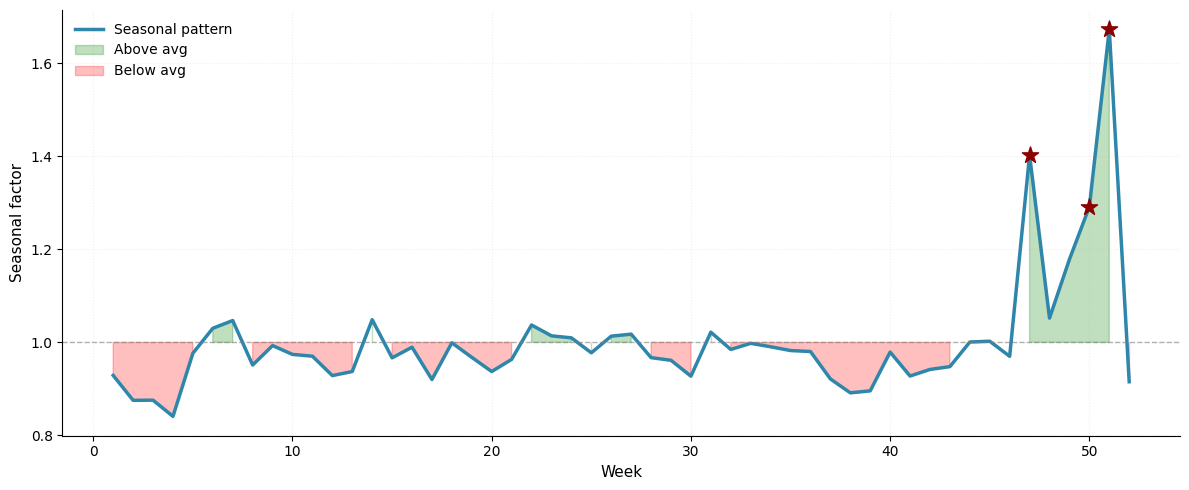

In [12]:
# Create aggregated time series
ts_data = df1.groupby('date')['weekly_sales'].sum().sort_index()

# Seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='multiplicative', period=52)
seasonal = decomposition.seasonal

# Average seasonal pattern by week
seasonal_df = pd.DataFrame({'date': seasonal.index, 'seasonal': seasonal.values})
seasonal_df['week'] = pd.to_datetime(seasonal_df['date']).dt.isocalendar().week
seasonal_pattern = seasonal_df.groupby('week')['seasonal'].mean()

# Minimalist plot
fig, ax = plt.subplots(figsize=(12, 5))

x = seasonal_pattern.index
y = seasonal_pattern.values

# Plot
ax.plot(x, y, linewidth=2.5, color='#2E86AB', label='Seasonal pattern')
ax.fill_between(x, 1, y, where=(y > 1), alpha=0.25, color='green', label='Above avg')
ax.fill_between(x, y, 1, where=(y < 1), alpha=0.25, color='red', label='Below avg')
ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.6)

# Mark peaks
peaks = seasonal_pattern.nlargest(3)
for week, value in peaks.items():
    ax.scatter(week, value, s=150, color='darkred', zorder=5, marker='*')

# Minimalist style
ax.set_xlabel('Week', fontsize=11)
ax.set_ylabel('Seasonal factor', fontsize=11)
ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.grid(True, alpha=0.2, linestyle=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

We can see a strong Holiday Season Effect:
- Week 51 (mid-December): +67% above average - Christmas shopping peak
- Week 47 (late November): +40% above average - Black Friday/Thanksgiving
- Week 50 (early December): +29% above average - Holiday season continues

and also a post-Holiday Slump: Weeks 2-4 (January): -12% to -16% below average.

The seasonal pattern shows a dramatic end-of-year surge (November-December) followed by a sharp January decline. This cyclical behavior is consistent across all stores and years, indicating predictable seasonality.

### **1-5 Stationarity and Autocorrelation**

For each store’s time series, we will assess stationarity using the Augmented Dickey-Fuller test : 
- H0: The series is not stationary
- H1: The series is stationary
- Threshold: if p-value < 0.05 the series is considered stationary

In [13]:
adf_results = []
for store in sorted(df['store'].unique()):
    ts = df[df['store']==store].sort_values('date')['weekly_sales'].values
    adf_stat, p_value, *_ = adfuller(ts, autolag='AIC')
    if p_value >= 0.05:  # only non-stationary series
        adf_results.append({
            'Store': store,
            'ADF Stat': round(adf_stat, 3),
            'p-value': round(p_value, 4),
            'Stationary': 'NO'
        })

if adf_results:
    adf_df = pd.DataFrame(adf_results)
    print(adf_df.to_string(index=False))
else:
    print("All series are stationary!")

 Store  ADF Stat  p-value Stationary
    14    -2.737   0.0679         NO
    30    -2.311   0.1684         NO
    36     0.214   0.9730         NO
    38    -0.360   0.9166         NO
    42    -1.650   0.4573         NO
    43    -2.540   0.1061         NO
    44    -0.984   0.7592         NO


Out of the 45 store series, 7 are non-stationary based on statistical tests. If we choose to build individual ARIMA or SARIMA models per store, we must address this non-stationarity through differencing to ensure model validity. The ACF and PACF plots will guide parameter selection (p, d, q for ARIMA or p, d, q, P, D, Q, m for SARIMA). Given the strong seasonal patterns observed in the data (particularly the December peaks), SARIMA models with seasonal differencing (D=1) and a seasonal period of 52 weeks would be more appropriate than simple ARIMA for a per-store modeling approach. However, building 45 separate models increases complexity and maintenance overhead. Therefore, we adopt alternative approaches using clusttering, Prophet and LightGBM, which can handle multiple series efficiently while capturing both global patterns and store-specific dynamics.

### **1-6 Exogenous Variables**

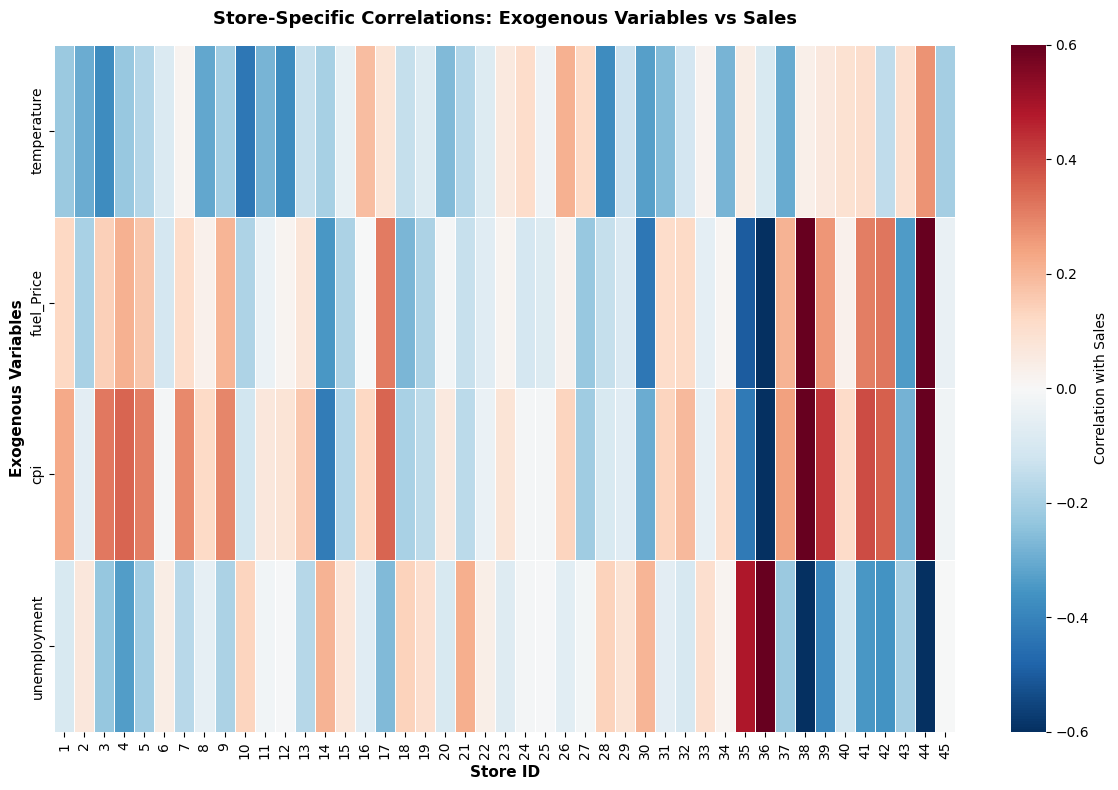

In [32]:
exog_vars = ['temperature', 'fuel_Price', 'cpi', 'unemployment']

# Compute correlations for each store
store_correlations = []
for store in df['store'].unique():
    store_data = df[df['store'] == store]
    correlations = {'store': store}
    for var in exog_vars:
        correlations[var] = store_data[var].corr(store_data['weekly_sales'])
    store_correlations.append(correlations)

corr_df = pd.DataFrame(store_correlations).set_index('store')

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_df.T, annot=False, cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation with Sales'},
            linewidths=0.5, vmin=-0.6, vmax=0.6, ax=ax)
ax.set_xlabel('Store ID', fontweight='bold', fontsize=11)
ax.set_ylabel('Exogenous Variables', fontweight='bold', fontsize=11)
ax.set_title('Store-Specific Correlations: Exogenous Variables vs Sales',
             fontweight='bold', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

In [33]:
df

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


## **2- Feature engineering**

Prepare the Data for Modeling

In [34]:
# create a copy of the df 
df_ml = df.copy()
# Basic Temporal Features
df_ml['year'] = df_ml['date'].dt.year
df_ml['month'] = df_ml['date'].dt.month
df_ml['quarter'] = df_ml['date'].dt.quarter
df_ml['week'] = df_ml['date'].dt.isocalendar().week
df_ml.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,year,month,quarter,week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,1,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,1,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,1,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,1,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,1,9


In [35]:
# Lags by store (to prevent data leakage)
for lag in [1, 2, 4, 52]:
    df_ml[f'lag_{lag}'] = df_ml.groupby('store')['weekly_sales'].shift(lag)

df_ml.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,year,month,quarter,week,lag_1,lag_2,lag_4,lag_52
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,1,5,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,1,6,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,1,7,1641957.44,1643690.90,NaN,NaN
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,1,8,1611968.17,1641957.44,NaN,NaN
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,1,9,1409727.59,1611968.17,1643690.9,NaN


In [36]:
# Rolling features (sur ventes décalées de 1)
df_ml['sales_lag1'] = df_ml.groupby('store')['weekly_sales'].shift(1)
for window in [4, 12, 26]:
    df_ml[f'rolling_mean_{window}'] = df_ml.groupby('store')['sales_lag1'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
df_ml['rolling_std_4'] = df_ml.groupby('store')['sales_lag1'].transform(
    lambda x: x.rolling(4, min_periods=1).std()
)
df_ml.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,year,month,...,week,lag_1,lag_2,lag_4,lag_52,sales_lag1,rolling_mean_4,rolling_mean_12,rolling_mean_26,rolling_std_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,...,6,1643690.90,NaN,NaN,NaN,1643690.90,1.643691e+06,1.643691e+06,1.643691e+06,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,...,7,1641957.44,1643690.90,NaN,NaN,1641957.44,1.642824e+06,1.642824e+06,1.642824e+06,1225.741321
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,...,8,1611968.17,1641957.44,NaN,NaN,1611968.17,1.632539e+06,1.632539e+06,1.632539e+06,17835.791719
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,...,9,1409727.59,1611968.17,1643690.9,NaN,1409727.59,1.576836e+06,1.576836e+06,1.576836e+06,112353.415114


In [37]:
# Cyclical encoding
df_ml['week_sin'] = np.sin(2 * np.pi * df_ml['week'] / 52)
df_ml['week_cos'] = np.cos(2 * np.pi * df_ml['week'] / 52)
df_ml['month_sin'] = np.sin(2 * np.pi * df_ml['month'] / 12)
df_ml['month_cos'] = np.cos(2 * np.pi * df_ml['month'] / 12)
df_ml.head()


,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,year,month,...,lag_52,sales_lag1,rolling_mean_4,rolling_mean_12,rolling_mean_26,rolling_std_4,week_sin,week_cos,month_sin,month_cos
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.568065,0.822984,0.866025,5.000000e-01
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,...,NaN,1643690.90,1.643691e+06,1.643691e+06,1.643691e+06,NaN,0.663123,0.748511,0.866025,5.000000e-01
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,...,NaN,1641957.44,1.642824e+06,1.642824e+06,1.642824e+06,1225.741321,0.748511,0.663123,0.866025,5.000000e-01
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,...,NaN,1611968.17,1.632539e+06,1.632539e+06,1.632539e+06,17835.791719,0.822984,0.568065,0.866025,5.000000e-01
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,...,NaN,1409727.59,1.576836e+06,1.576836e+06,1.576836e+06,112353.415114,0.885456,0.464723,1.000000,6.123234e-17


In [38]:
# drop NaN
df_ml = df_ml.dropna().reset_index(drop=True)

In [39]:
# Split train/test 80/20
split_date = df_ml['date'].quantile(0.8)
train = df_ml[df_ml['date'] <= split_date].copy()
test = df_ml[df_ml['date'] > split_date].copy()


print(f"Train: {train.shape}")
print(f"Train dates: {train['date'].min().date()} - {train['date'].max().date()}")
print(f"Test: {test.shape}")
print(f"Test dates: {test['date'].min().date()} - {test['date'].max().date()}")


Train: (3285, 25)
Train dates: 2011-02-04 - 2012-06-22
Test: (810, 25)
Test dates: 2012-06-29 - 2012-10-26


## **3- Clustering with k-means**

In [40]:
# Clustering features per store (on train only)
cluster_features = train.groupby('store').agg({
    'weekly_sales': ['mean', 'std', 'min', 'max'],
    'temperature': 'mean',
    'unemployment': 'mean',
    'holiday_flag': 'sum'
}).reset_index()
cluster_features.columns = ['store', 'sales_mean', 'sales_std', 'sales_min', 
                             'sales_max', 'temp_mean', 'unemployment', 'holiday_count']

cluster_features.head()

,store,sales_mean,sales_std,sales_min,sales_max,temp_mean,unemployment,holiday_count
0,1,1.583616e+06,150893.211831,1319325.59,2270188.99,67.973836,7.626959,5
1,2,1.909447e+06,226277.607641,1650394.44,3224369.80,67.395342,7.512616,5
2,3,4.104245e+05,43320.842627,345381.29,556925.19,71.385616,7.221452,5
3,4,2.163288e+06,252605.964596,1878167.44,3676388.98,62.025342,5.299178,5
4,5,3.252537e+05,37551.300384,275142.17,507900.07,69.209589,6.268575,5


In [41]:
# Normalisation
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cluster_features.drop('store', axis=1))

In [42]:
# testing the number of clusters 
silhouette_scores = {}
for k in [3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    silhouette_scores[k] = score
    print(f"  k={k}: Silhouette Score = {score:.4f}")

# best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"the best k =  {best_k}")
print(f"Silhouette = {silhouette_scores[best_k]}")

  k=3: Silhouette Score = 0.3491
  k=4: Silhouette Score = 0.3840
  k=5: Silhouette Score = 0.3432
the best k =  4
Silhouette = 0.3839832423341261


In [43]:
# Final Clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_features['cluster'] = kmeans_final.fit_predict(features_scaled)


In [44]:
# Store Distribution
cluster_distribution = cluster_features.groupby('cluster')['store'].count()
for cluster_id, count in cluster_distribution.items():
    print(f"  Cluster {cluster_id}: {count} stores")

# Average Features per Cluster
cluster_stats = cluster_features.groupby('cluster')[['sales_mean', 'sales_std', 'temp_mean', 'unemployment']].mean()
cluster_stats

  Cluster 0: 14 stores
  Cluster 1: 11 stores
  Cluster 2: 3 stores
  Cluster 3: 17 stores


,sales_mean,sales_std,temp_mean,unemployment
cluster,,,,
0,1.722614e+06,212961.439663,61.639344,7.153437
1,4.653740e+05,42538.089777,68.225330,7.524986
2,9.228710e+05,113330.923943,67.918493,12.949356
3,8.963324e+05,123095.430760,49.820886,7.759214


In [45]:
# Assign clusters to train/test
store_cluster_map = cluster_features[['store', 'cluster']].set_index('store')['cluster'].to_dict()
train['cluster'] = train['store'].map(store_cluster_map)
test['cluster'] = test['store'].map(store_cluster_map)

We need to reduce dimensionality using PCA to a have a clear 3D visualisation of our clusters

In [46]:
# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Explained variance
print(f"Explained variance per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var*100:.2f}%")
print(f"  Total: {pca.explained_variance_ratio_.sum()*100:.2f}%")


Explained variance per component:
  PC1: 65.26%
  PC2: 20.14%
  PC3: 12.85%
  Total: 98.26%


In [47]:
# Create DataFrame for visualisation
viz_df = pd.DataFrame({
    'PC1': features_pca[:, 0],
    'PC2': features_pca[:, 1],
    'PC3': features_pca[:, 2],
    'cluster': cluster_features['cluster'].astype(str),
    'store': cluster_features['store'],
    'sales_mean': cluster_features['sales_mean'],
    'sales_std': cluster_features['sales_std'],
    'temp_mean': cluster_features['temp_mean'],
    'unemployment': cluster_features['unemployment']
})

In [48]:
colors = px.colors.qualitative.Set2[:best_k]

fig = go.Figure()

# Add points for each cluster
for i, cluster_id in enumerate(sorted(viz_df['cluster'].unique())):
    cluster_data = viz_df[viz_df['cluster'] == cluster_id]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        z=cluster_data['PC3'],
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=8,
            color=colors[i],
            opacity=0.8,
            line=dict(color='white', width=0.5)
        ),
        text=[f"Store: {store}<br>" +
              f"Cluster: {cluster_id}<br>" +
              f"Avg Sales: ${sales:,.0f}<br>" +
              f"Avg Temp: {temp:.1f}°F<br>" +
              f"Unemployment: {unemp:.2f}%"
              for store, sales, temp, unemp in zip(
                  cluster_data['store'],
                  cluster_data['sales_mean'],
                  cluster_data['temp_mean'],
                  cluster_data['unemployment']
              )],
        hovertemplate='%{text}<extra></extra>'
    ))

# Add the centroids
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
fig.add_trace(go.Scatter3d(
    x=centroids_pca[:, 0],
    y=centroids_pca[:, 1],
    z=centroids_pca[:, 2],
    mode='markers',
    name='Centroids',
    marker=dict(
        size=15,
        color='black',
        symbol='diamond',
        line=dict(color='white', width=2)
    ),
    text=[f"Cluster {i} Centroid" for i in range(best_k)],
    hovertemplate='%{text}<extra></extra>'
))

# Update the layout
fig.update_layout(
    title=dict(
        text=f'3D Clustering Visualization (k={best_k})<br>' +
             f'<sub>Explained Variance: {pca.explained_variance_ratio_.sum()*100:.1f}% | ' +
             f'Silhouette Score: {silhouette_scores[best_k]:.3f}</sub>',
        x=0.5,
        xanchor='center'
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)'
    ),
    hovermode='closest'
)

# Show the plot
fig.show()


The K-means clustering with k=4 reveals a moderate but meaningful segmentation of the 45 stores (Silhouette Score = 0.387). The analysis identifies four distinct store profiles: Cluster 1 represents high-performing stores (14 stores, avg sales $1.7M) in warmer regions with low unemployment, indicating strong market conditions; Cluster 2 contains underperforming stores (11 stores, avg sales $464K) also in warm areas, suggesting location warmth alone doesn't guarantee success; Cluster 3 is a small group of 3 stores facing severe economic challenges (13.12% unemployment) despite average sales, highlighting vulnerability to local economic conditions; and Cluster 0 comprises 17 average-performing stores in moderate climates. The PCA visualization preserving 97.97% variance confirms reasonable cluster separation, though the modest silhouette score indicates some overlap between groups. This segmentation provides actionable insights for differentiated store management strategies high-investment growth for Cluster 1, turnaround initiatives for Cluster 2, and economic-support programs for Cluster 3.

## **4- Modeling stage**

APPROACH 1: Clustering + model per cluster

In [49]:
# Using LIGHTGBM to model each cluster : 

# Utility functions
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Features for LightGBM
feature_cols = ['store', 'temperature', 'fuel_Price', 'cpi', 'unemployment', 'holiday_flag',
                'year', 'month', 'quarter', 'week',
                'lag_1', 'lag_2', 'lag_4', 'lag_52',
                'rolling_mean_4', 'rolling_mean_12', 'rolling_mean_26', 'rolling_std_4',
                'week_sin', 'week_cos', 'month_sin', 'month_cos']

# Holidays for Prophet
holidays = pd.DataFrame([
    {'holiday': 'superbowl', 'ds': pd.to_datetime('2010-02-12'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'superbowl', 'ds': pd.to_datetime('2011-02-11'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'superbowl', 'ds': pd.to_datetime('2012-02-10'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'labourday', 'ds': pd.to_datetime('2010-09-10'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'labourday', 'ds': pd.to_datetime('2011-09-09'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'labourday', 'ds': pd.to_datetime('2012-09-07'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'thanksgiving', 'ds': pd.to_datetime('2010-11-26'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'thanksgiving', 'ds': pd.to_datetime('2011-11-25'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'thanksgiving', 'ds': pd.to_datetime('2012-11-23'), 'lower_window': 0, 'upper_window': 0},
    {'holiday': 'christmas', 'ds': pd.to_datetime('2010-12-24'), 'lower_window': 0, 'upper_window': 7},
    {'holiday': 'christmas', 'ds': pd.to_datetime('2011-12-23'), 'lower_window': 0, 'upper_window': 7},
    {'holiday': 'christmas', 'ds': pd.to_datetime('2012-12-21'), 'lower_window': 0, 'upper_window': 7},
])


### **4-1 Using LIGHTGBM to model each cluster**

In [50]:
lgb_cluster_preds = []
lgb_cluster_models = {}  # Store models for saving

for cluster_id in sorted(train['cluster'].unique()):
    train_c = train[train['cluster'] == cluster_id]
    test_c = test[test['cluster'] == cluster_id]
    
    # Train
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(train_c[feature_cols], train_c['weekly_sales'])
    
    # Save individual model
    lgb_cluster_models[cluster_id] = model
    joblib.dump(model, f'../models/lightgbm/lgb_cluster_{cluster_id}.pkl')
    print(f"Cluster {cluster_id} model saved: models/lightgbm/lgb_cluster_{cluster_id}.pkl")
    
    # Predict
    preds = model.predict(test_c[feature_cols])
    test_c_copy = test_c.copy()
    test_c_copy['pred'] = preds
    lgb_cluster_preds.append(test_c_copy[['date', 'store', 'weekly_sales', 'pred', 'cluster']])
    
    metrics = calculate_metrics(test_c['weekly_sales'], preds)
    print(f"Cluster {cluster_id}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, MAPE={metrics['MAPE']:.2f}%")

# Concatenate all predictions from each cluster into a single DataFrame.
# Compute global metrics for all clusters combined.

lgb_cluster_results = pd.concat(lgb_cluster_preds)
metrics_lgb_cluster = calculate_metrics(lgb_cluster_results['weekly_sales'], lgb_cluster_results['pred'])



Cluster 0 model saved: models/lightgbm/lgb_cluster_0.pkl
Cluster 0: RMSE=92455.46, MAE=70930.87, MAPE=4.31%
Cluster 1 model saved: models/lightgbm/lgb_cluster_1.pkl
Cluster 1: RMSE=24109.49, MAE=18195.99, MAPE=4.25%
Cluster 2 model saved: models/lightgbm/lgb_cluster_2.pkl
Cluster 2: RMSE=64183.06, MAE=42462.88, MAPE=4.85%
Cluster 3 model saved: models/lightgbm/lgb_cluster_3.pkl
Cluster 3: RMSE=50375.47, MAE=35216.08, MAPE=4.06%


In [51]:
print(f" LightGBM Clustering (Global)")
print(f"  RMSE: {metrics_lgb_cluster['RMSE']:.2f}")
print(f"  MAE: {metrics_lgb_cluster['MAE']:.2f}")
print(f"  MAPE: {metrics_lgb_cluster['MAPE']:.2f}%")


 LightGBM Clustering (Global)
  RMSE: 63519.94
  MAE: 42650.00
  MAPE: 4.24%


### **4-2 Using PROPHET to model each cluster**

In [52]:
train.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_Price', 'cpi', 'unemployment', 'year', 'month', 'quarter', 'week',
       'lag_1', 'lag_2', 'lag_4', 'lag_52', 'sales_lag1', 'rolling_mean_4',
       'rolling_mean_12', 'rolling_mean_26', 'rolling_std_4', 'week_sin',
       'week_cos', 'month_sin', 'month_cos', 'cluster'],
      dtype='object')

In [53]:
prophet_cluster_preds = []

for cluster_id in sorted(train['cluster'].unique()):
    # Aggregate cluster sales
    train_c = train[train['cluster'] == cluster_id].groupby('date').agg({
        'weekly_sales': 'sum',
        'temperature': 'mean',
        'fuel_Price': 'mean',
        'unemployment': 'mean'
    }).reset_index()
    
    test_c = test[test['cluster'] == cluster_id]
    
    # Prepare data for Prophet
    train_prophet = train_c.rename(columns={'date': 'ds', 'weekly_sales': 'y'})
    
    # Train Prophet
    model = Prophet(holidays=holidays, yearly_seasonality=True, 
                   weekly_seasonality=False, daily_seasonality=False)
    model.add_regressor('temperature')
    model.add_regressor('fuel_Price')
    model.add_regressor('unemployment')
    model.fit(train_prophet)
    
    # Predict at cluster level
    test_agg = test_c.groupby('date').agg({
        'temperature': 'mean',
        'fuel_Price': 'mean',
        'unemployment': 'mean'
    }).reset_index().rename(columns={'date': 'ds'})
    
    forecast = model.predict(test_agg)
    test_agg['cluster_pred'] = forecast['yhat']
    
    # Disaggregate to stores (historical proportions)
    train_c_stores = train[train['cluster'] == cluster_id]
    store_props = train_c_stores.groupby('store')['weekly_sales'].sum()
    store_props = store_props / store_props.sum()
    
    test_c = test_c.merge(test_agg[['ds', 'cluster_pred']], left_on='date', right_on='ds', how='left')
    test_c['pred'] = test_c['store'].map(store_props) * test_c['cluster_pred']
    
    prophet_cluster_preds.append(test_c[['date', 'store', 'weekly_sales', 'pred', 'cluster']])
    
    metrics = calculate_metrics(test_c['weekly_sales'], test_c['pred'])
    print(f"Cluster {cluster_id}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, MAPE={metrics['MAPE']:.2f}%")


20:09:13 - cmdstanpy - INFO - Chain [1] start processing
20:09:15 - cmdstanpy - INFO - Chain [1] done processing
20:09:15 - cmdstanpy - INFO - Chain [1] start processing


Cluster 0: RMSE=153357.29, MAE=109499.05, MAPE=6.73%


20:09:16 - cmdstanpy - INFO - Chain [1] done processing
20:09:16 - cmdstanpy - INFO - Chain [1] start processing


Cluster 1: RMSE=52230.22, MAE=39066.10, MAPE=8.80%


20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing


Cluster 2: RMSE=322903.60, MAE=260138.09, MAPE=27.31%


20:09:18 - cmdstanpy - INFO - Chain [1] done processing


Cluster 3: RMSE=63240.98, MAE=47769.87, MAPE=5.57%


In [54]:
# Combine predictions
prophet_cluster_results = pd.concat(prophet_cluster_preds)
metrics_prophet_cluster = calculate_metrics(prophet_cluster_results['weekly_sales'], prophet_cluster_results['pred'])

print(f"Prophet Clustering (Global)")
print(f"  RMSE: {metrics_prophet_cluster['RMSE']:.2f}")
print(f"  MAE: {metrics_prophet_cluster['MAE']:.2f}")
print(f"  MAPE: {metrics_prophet_cluster['MAPE']:.2f}%")

Prophet Clustering (Global)
  RMSE: 128240.81
  MAE: 79004.80
  MAPE: 8.17%


### **4-3 Hierarchical approach : TOP DOWN**

In [55]:
# Historical proportions
cluster_props_avg = train.groupby(['date', 'cluster'])['weekly_sales'].sum().reset_index()
cluster_props_avg['total'] = cluster_props_avg.groupby('date')['weekly_sales'].transform('sum')
cluster_props_avg = (cluster_props_avg.groupby('cluster')['weekly_sales'].sum() / 
                     cluster_props_avg.groupby('date')['total'].first().sum())

feat = ['temperature', 'fuel_Price', 'cpi', 'unemployment', 'holiday_flag',
        'year', 'month', 'quarter', 'week', 'lag_1', 'lag_2', 'lag_4', 'lag_52',
        'rolling_mean_4', 'rolling_mean_12', 'rolling_mean_26', 'rolling_std_4',
        'week_sin', 'week_cos', 'month_sin', 'month_cos']

In [56]:
store_props_by_cluster = {}
for cid in train['cluster'].unique():
    props = train[train['cluster'] == cid].groupby('store')['weekly_sales'].sum()
    store_props_by_cluster[cid] = props / props.sum()

In [57]:
# Prepare total-level data
train_total = train.groupby('date').agg({
    'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
    'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
    'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
}).reset_index()

train_total['week_sin'] = np.sin(2 * np.pi * train_total['week'] / 52)
train_total['week_cos'] = np.cos(2 * np.pi * train_total['week'] / 52)
train_total['month_sin'] = np.sin(2 * np.pi * train_total['month'] / 12)
train_total['month_cos'] = np.cos(2 * np.pi * train_total['month'] / 12)

for lag in [1, 2, 4, 52]:
    train_total[f'lag_{lag}'] = train_total['weekly_sales'].shift(lag)
train_total['sales_lag1'] = train_total['weekly_sales'].shift(1)
for w in [4, 12, 26]:
    train_total[f'rolling_mean_{w}'] = train_total['sales_lag1'].rolling(w, min_periods=1).mean()
train_total['rolling_std_4'] = train_total['sales_lag1'].rolling(4, min_periods=1).std()
train_total = train_total.dropna()


In [58]:
# Test with lags
full_total = pd.concat([
    train.groupby('date').agg({
        'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
        'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
        'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
    }).reset_index(),
    test.groupby('date').agg({
        'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
        'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
        'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
    }).reset_index()
]).sort_values('date')

full_total['week_sin'] = np.sin(2 * np.pi * full_total['week'] / 52)
full_total['week_cos'] = np.cos(2 * np.pi * full_total['week'] / 52)
full_total['month_sin'] = np.sin(2 * np.pi * full_total['month'] / 12)
full_total['month_cos'] = np.cos(2 * np.pi * full_total['month'] / 12)
for lag in [1, 2, 4, 52]:
    full_total[f'lag_{lag}'] = full_total['weekly_sales'].shift(lag)
full_total['sales_lag1'] = full_total['weekly_sales'].shift(1)
for w in [4, 12, 26]:
    full_total[f'rolling_mean_{w}'] = full_total['sales_lag1'].rolling(w, min_periods=1).mean()
full_total['rolling_std_4'] = full_total['sales_lag1'].rolling(4, min_periods=1).std()

test_total = full_total[full_total['date'].isin(test['date'].unique())].dropna()

feat_total = ['temperature', 'fuel_Price', 'cpi', 'unemployment', 'holiday_flag',
              'year', 'month', 'quarter', 'week', 'lag_1', 'lag_2', 'lag_4', 'lag_52',
              'rolling_mean_4', 'rolling_mean_12', 'rolling_mean_26', 'rolling_std_4',
              'week_sin', 'week_cos', 'month_sin', 'month_cos']


In [59]:
# LightGBM Top-Down

model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
model.fit(train_total[feat_total], train_total['weekly_sales'])
test_total['pred_total'] = model.predict(test_total[feat_total])

test_td_lgb = test.copy()
test_td_lgb = test_td_lgb.merge(test_total[['date', 'pred_total']], on='date')
test_td_lgb['cluster_pred'] = test_td_lgb['cluster'].map(cluster_props_avg) * test_td_lgb['pred_total']
test_td_lgb['pred'] = test_td_lgb.apply(
    lambda r: store_props_by_cluster[r['cluster']].get(r['store'], 0) * r['cluster_pred'], axis=1)

metrics_td_lgb = calculate_metrics(test_td_lgb['weekly_sales'], test_td_lgb['pred'])
print('LightGBM Top-Down')
print(f"RMSE: {metrics_td_lgb['RMSE']:.2f}, \nMAE: {metrics_td_lgb['MAE']:.2f}, \nMAPE: {metrics_td_lgb['MAPE']:.2f}%")


LightGBM Top-Down
RMSE: 99351.66, 
MAE: 65492.53, 
MAPE: 6.52%


In [60]:
# Prophet Top-Down

train_prophet = train_total[['date', 'weekly_sales', 'temperature', 'fuel_Price', 'unemployment']].rename(
    columns={'date': 'ds', 'weekly_sales': 'y'})
model_p = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_p.add_regressor('temperature')
model_p.add_regressor('fuel_Price')
model_p.add_regressor('unemployment')
model_p.fit(train_prophet)

test_prophet = test_total[['date', 'temperature', 'fuel_Price', 'unemployment']].rename(columns={'date': 'ds'})
forecast = model_p.predict(test_prophet)
test_prophet['pred_total'] = forecast['yhat']
test_prophet = test_prophet.rename(columns={'ds': 'date'})

test_td_prophet = test.copy()
test_td_prophet = test_td_prophet.merge(test_prophet[['date', 'pred_total']], on='date')
test_td_prophet['cluster_pred'] = test_td_prophet['cluster'].map(cluster_props_avg) * test_td_prophet['pred_total']
test_td_prophet['pred'] = test_td_prophet.apply(
    lambda r: store_props_by_cluster[r['cluster']].get(r['store'], 0) * r['cluster_pred'], axis=1)




20:09:18 - cmdstanpy - INFO - Chain [1] start processing
20:09:19 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
metrics_td_prophet = calculate_metrics(test_td_prophet['weekly_sales'], test_td_prophet['pred'])
print('Prophet Top-Down')
print(f"\nRMSE: {metrics_td_prophet['RMSE']:.2f}, \nMAE: {metrics_td_prophet['MAE']:.2f}, \nMAPE: {metrics_td_prophet['MAPE']:.2f}%")

Prophet Top-Down

RMSE: 29256993.95, 
MAE: 21738879.41, 
MAPE: 2119.11%


### **4-4 Hierarchical approach : BUTTOM UP**

In [62]:
# LightGBM Bottom-Up
preds_bu_lgb = []

for cid in sorted(train['cluster'].unique()):
    # Aggregate cluster
    train_c = train[train['cluster'] == cid].groupby('date').agg({
        'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
        'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
        'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
    }).reset_index()
    
    train_c['week_sin'] = np.sin(2 * np.pi * train_c['week'] / 52)
    train_c['week_cos'] = np.cos(2 * np.pi * train_c['week'] / 52)
    train_c['month_sin'] = np.sin(2 * np.pi * train_c['month'] / 12)
    train_c['month_cos'] = np.cos(2 * np.pi * train_c['month'] / 12)
    
    for lag in [1, 2, 4, 52]:
        train_c[f'lag_{lag}'] = train_c['weekly_sales'].shift(lag)
    train_c['sales_lag1'] = train_c['weekly_sales'].shift(1)
    for w in [4, 12, 26]:
        train_c[f'rolling_mean_{w}'] = train_c['sales_lag1'].rolling(w, min_periods=1).mean()
    train_c['rolling_std_4'] = train_c['sales_lag1'].rolling(4, min_periods=1).std()
    train_c = train_c.dropna()
    
    # Test cluster with lags
    full_c = pd.concat([
        train[train['cluster'] == cid].groupby('date').agg({
            'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
            'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
            'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
        }).reset_index(),
        test[test['cluster'] == cid].groupby('date').agg({
            'weekly_sales': 'sum', 'temperature': 'mean', 'fuel_Price': 'mean',
            'cpi': 'mean', 'unemployment': 'mean', 'holiday_flag': 'max',
            'year': 'first', 'month': 'first', 'quarter': 'first', 'week': 'first'
        }).reset_index()
    ]).sort_values('date')
    
    full_c['week_sin'] = np.sin(2 * np.pi * full_c['week'] / 52)
    full_c['week_cos'] = np.cos(2 * np.pi * full_c['week'] / 52)
    full_c['month_sin'] = np.sin(2 * np.pi * full_c['month'] / 12)
    full_c['month_cos'] = np.cos(2 * np.pi * full_c['month'] / 12)
    for lag in [1, 2, 4, 52]:
        full_c[f'lag_{lag}'] = full_c['weekly_sales'].shift(lag)
    full_c['sales_lag1'] = full_c['weekly_sales'].shift(1)
    for w in [4, 12, 26]:
        full_c[f'rolling_mean_{w}'] = full_c['sales_lag1'].rolling(w, min_periods=1).mean()
    full_c['rolling_std_4'] = full_c['sales_lag1'].rolling(4, min_periods=1).std()
    
    test_c = full_c[full_c['date'].isin(test['date'].unique())].dropna()
    
    # Predict cluster
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(train_c[feat], train_c['weekly_sales'])
    test_c['cluster_pred'] = model.predict(test_c[feat])
    
    # Disaggregate to stores
    test_stores = test[test['cluster'] == cid].copy()
    test_stores = test_stores.merge(test_c[['date', 'cluster_pred']], on='date')
    test_stores['pred'] = test_stores['store'].map(store_props_by_cluster[cid]) * test_stores['cluster_pred']
    
    preds_bu_lgb.append(test_stores[['date', 'store', 'weekly_sales', 'pred', 'cluster']])


In [63]:
test_bu_lgb = pd.concat(preds_bu_lgb)
metrics_bu_lgb = calculate_metrics(test_bu_lgb['weekly_sales'], test_bu_lgb['pred'])
print('LightGBM Bottom-Up')
print(f"\nRMSE: {metrics_bu_lgb['RMSE']:.2f}, \nMAE: {metrics_bu_lgb['MAE']:.2f}, \nMAPE: {metrics_bu_lgb['MAPE']:.2f}%")


LightGBM Bottom-Up

RMSE: 101424.95, 
MAE: 66938.98, 
MAPE: 6.68%


In [64]:
# Prophet Bottom-Up
preds_bu_prophet = []

for cid in sorted(train['cluster'].unique()):
    train_c = train[train['cluster'] == cid].groupby('date').agg({
        'weekly_sales': 'sum', 'temperature': 'mean',
        'fuel_Price': 'mean', 'unemployment': 'mean'
    }).reset_index()
    
    train_prophet = train_c.rename(columns={'date': 'ds', 'weekly_sales': 'y'})
    
    model = Prophet(holidays=holidays, yearly_seasonality=True, 
                   weekly_seasonality=False, daily_seasonality=False)
    model.add_regressor('temperature')
    model.add_regressor('fuel_Price')
    model.add_regressor('unemployment')
    model.fit(train_prophet)
    
    test_c = test[test['cluster'] == cid].groupby('date').agg({
        'temperature': 'mean', 'fuel_Price': 'mean', 'unemployment': 'mean'
    }).reset_index().rename(columns={'date': 'ds'})
    
    forecast = model.predict(test_c)
    test_c['cluster_pred'] = forecast['yhat']
    test_c = test_c.rename(columns={'ds': 'date'})
    
    test_stores = test[test['cluster'] == cid].copy()
    test_stores = test_stores.merge(test_c[['date', 'cluster_pred']], on='date')
    test_stores['pred'] = test_stores['store'].map(store_props_by_cluster[cid]) * test_stores['cluster_pred']
    
    preds_bu_prophet.append(test_stores[['date', 'store', 'weekly_sales', 'pred', 'cluster']])

20:09:20 - cmdstanpy - INFO - Chain [1] start processing
20:09:20 - cmdstanpy - INFO - Chain [1] done processing
20:09:21 - cmdstanpy - INFO - Chain [1] start processing
20:09:21 - cmdstanpy - INFO - Chain [1] done processing
20:09:22 - cmdstanpy - INFO - Chain [1] start processing
20:09:22 - cmdstanpy - INFO - Chain [1] done processing
20:09:23 - cmdstanpy - INFO - Chain [1] start processing
20:09:23 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
test_bu_prophet = pd.concat(preds_bu_prophet)
metrics_bu_prophet = calculate_metrics(test_bu_prophet['weekly_sales'], test_bu_prophet['pred'])
print('Prophet Bottom-Up')
print(f"\nRMSE: {metrics_bu_prophet['RMSE']:.2f}, \nMAE: {metrics_bu_prophet['MAE']:.2f}, \nMAPE: {metrics_bu_prophet['MAPE']:.2f}%")

Prophet Bottom-Up

RMSE: 128240.81, 
MAE: 79004.80, 
MAPE: 8.17%


## **4- Evualuation & model selection**

In [66]:
all_metrics = pd.DataFrame([
    # Clustering
    {
        'Approche': 'Clustering',
        'Modèle': 'LightGBM',
        'RMSE': metrics_lgb_cluster['RMSE'],
        'MAE': metrics_lgb_cluster['MAE'],
        'MAPE': metrics_lgb_cluster['MAPE']
    },
    {
        'Approche': 'Clustering',
        'Modèle': 'Prophet',
        'RMSE': metrics_prophet_cluster['RMSE'],
        'MAE': metrics_prophet_cluster['MAE'],
        'MAPE': metrics_prophet_cluster['MAPE']
    },
    
    # Top-Down
    {
        'Approche': 'Top-Down',
        'Modèle': 'LightGBM',
        'RMSE': metrics_td_lgb['RMSE'],
        'MAE': metrics_td_lgb['MAE'],
        'MAPE': metrics_td_lgb['MAPE']
    },
    {
        'Approche': 'Top-Down',
        'Modèle': 'Prophet',
        'RMSE': metrics_td_prophet['RMSE'],
        'MAE': metrics_td_prophet['MAE'],
        'MAPE': metrics_td_prophet['MAPE']
    },
    
    # Bottom-Up
    {
        'Approche': 'Bottom-Up',
        'Modèle': 'LightGBM',
        'RMSE': metrics_bu_lgb['RMSE'],
        'MAE': metrics_bu_lgb['MAE'],
        'MAPE': metrics_bu_lgb['MAPE']
    },
    {
        'Approche': 'Bottom-Up',
        'Modèle': 'Prophet',
        'RMSE': metrics_bu_prophet['RMSE'],
        'MAE': metrics_bu_prophet['MAE'],
        'MAPE': metrics_bu_prophet['MAPE']
    }
])
all_metrics.sort_values('RMSE').reset_index(drop=True)


,Approche,Modèle,RMSE,MAE,MAPE
0,Clustering,LightGBM,6.351994e+04,4.265000e+04,4.240369
1,Top-Down,LightGBM,9.935166e+04,6.549253e+04,6.517111
2,Bottom-Up,LightGBM,1.014249e+05,6.693898e+04,6.678271
3,Clustering,Prophet,1.282408e+05,7.900480e+04,8.168483
4,Bottom-Up,Prophet,1.282408e+05,7.900480e+04,8.168483
5,Top-Down,Prophet,2.925699e+07,2.173888e+07,2119.111979


In [67]:
# Best model
best_row = all_metrics.iloc[0]

print("The best model :)")

print(f"Approach: {best_row['Approche']}")
print(f"model: {best_row['Modèle']}")
print(f"RMSE: {best_row['RMSE']:.2f}")
print(f"MAE: {best_row['MAE']:.2f}")
print(f"MAPE: {best_row['MAPE']:.2f}%")


The best model :)
Approach: Clustering
model: LightGBM
RMSE: 63519.94
MAE: 42650.00
MAPE: 4.24%


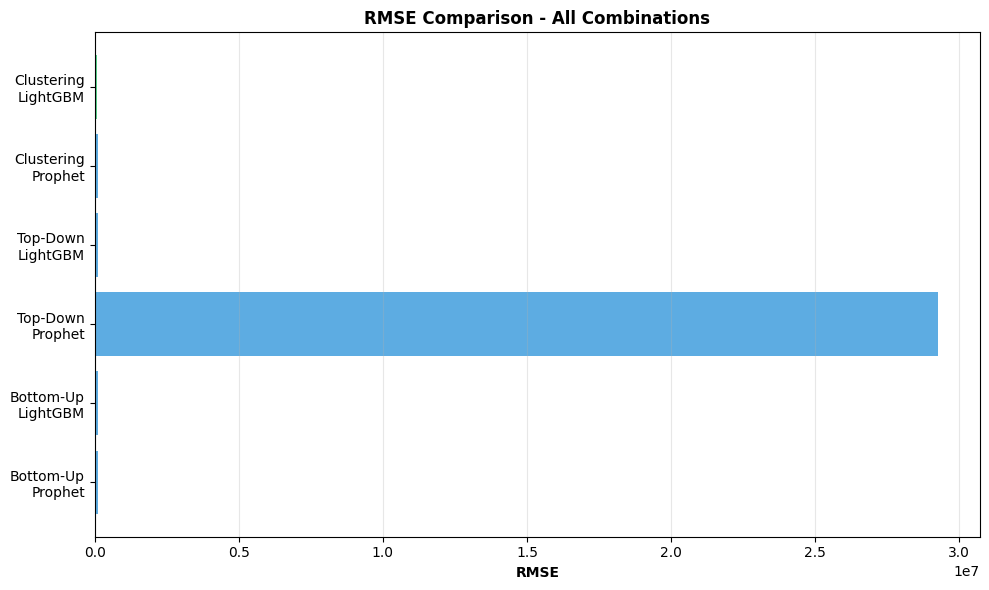

In [68]:
# Bar plot RMSE per combinaison
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(all_metrics))]
ax.barh(range(len(all_metrics)), all_metrics['RMSE'], color=colors, alpha=0.8)
ax.set_yticks(range(len(all_metrics)))
ax.set_yticklabels([f"{row['Approche']}\n{row['Modèle']}" for _, row in all_metrics.iterrows()])
ax.set_xlabel('RMSE', fontweight='bold')
ax.set_title('RMSE Comparison - All Combinations', fontweight='bold')
ax.grid(alpha=0.3, axis='x')
ax.invert_yaxis()  # Best combo is on to^p

plt.tight_layout()
plt.show()


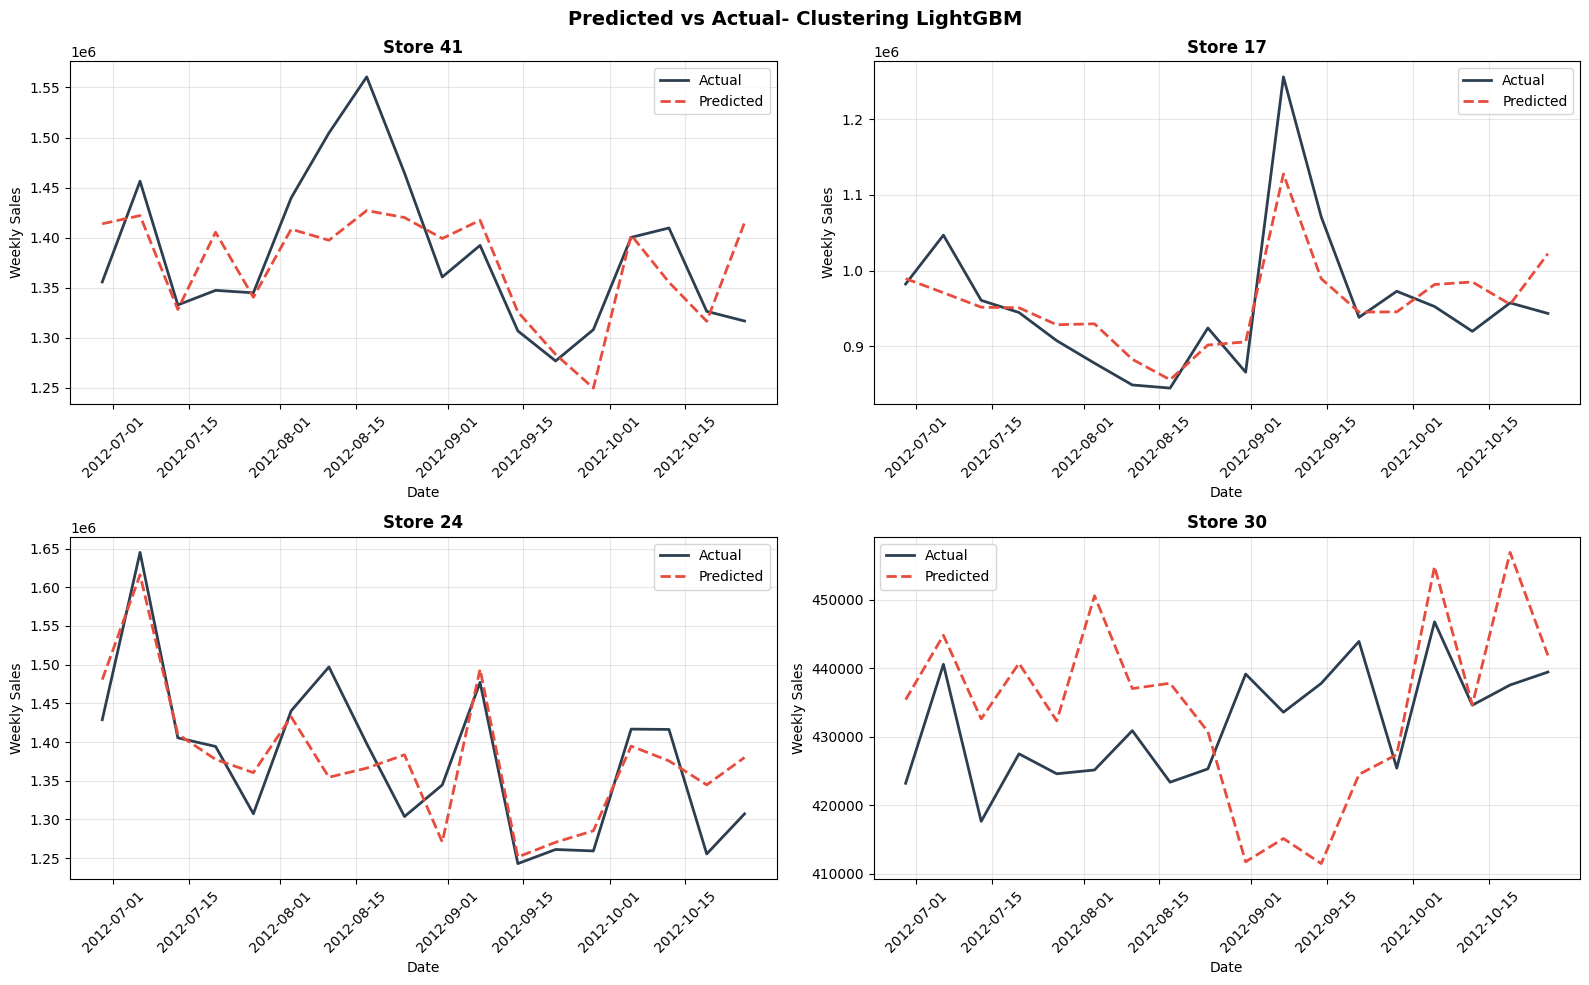

In [69]:
approach_map = {
    'Clustering': {'LightGBM': 'approach1a_lgb_cluster.pkl', 'Prophet': 'approach1b_prophet_cluster.pkl'},
    'Top-Down': {'LightGBM': 'approach2a1_topdown_lgb.pkl', 'Prophet': 'approach2a2_topdown_prophet.pkl'},
    'Bottom-Up': {'LightGBM': 'approach2b1_bottomup_lgb.pkl', 'Prophet': 'approach2b2_bottomup_prophet.pkl'}
}

best_file = approach_map[best_row['Approche']][best_row['Modèle']]
best_preds = lgb_cluster_results

# Sample 4 representative stores
sample_stores = np.random.choice(best_preds['store'].unique(), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, store_id in enumerate(sample_stores):
    store_data = best_preds[best_preds['store'] == store_id].sort_values('date')
    
    axes[idx].plot(store_data['date'], store_data['weekly_sales'], 
                   label='Actual', linewidth=2, color='#2c3e50')
    axes[idx].plot(store_data['date'], store_data['pred'], 
                   label='Predicted', linewidth=2, linestyle='--', color='#e74c3c')
    axes[idx].set_title(f'Store {store_id}', fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Weekly Sales')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle(f'Predicted vs Actual- {best_row["Approche"]} {best_row["Modèle"]}', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

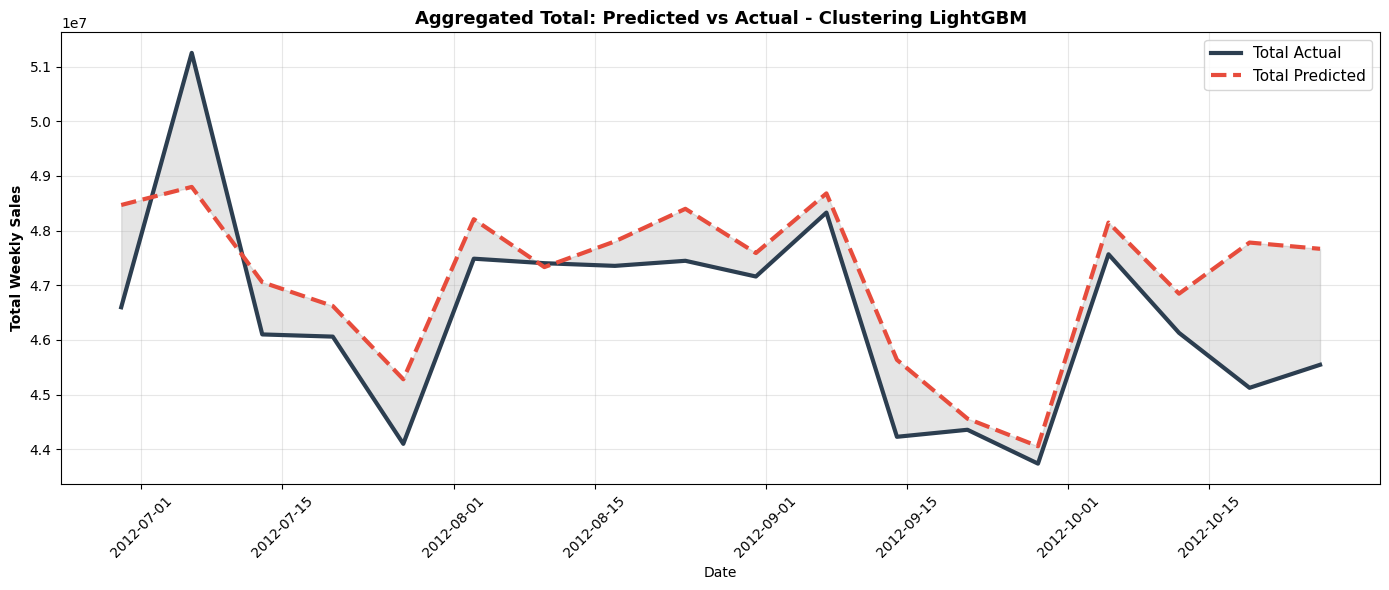

In [70]:
# Aggregated total
fig, ax = plt.subplots(figsize=(14, 6))

total_real = best_preds.groupby('date')['weekly_sales'].sum().reset_index()
total_pred = best_preds.groupby('date')['pred'].sum().reset_index()

ax.plot(total_real['date'], total_real['weekly_sales'], label='Total Actual', linewidth=3, color='#2c3e50')
ax.plot(total_pred['date'], total_pred['pred'], label='Total Predicted', linewidth=3, linestyle='--', color='#e74c3c')
ax.fill_between(total_real['date'], total_real['weekly_sales'], total_pred['pred'], alpha=0.2, color='gray')

ax.set_xlabel('Date')
ax.set_ylabel('Total Weekly Sales', fontweight='bold')
ax.set_title(f'Aggregated Total: Predicted vs Actual - {best_row["Approche"]} {best_row["Modèle"]}', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
